In [1]:
using DataFrames
using Plots, Rsvg
using Chemfiles, FileIO
home = "/home/german/labo/18/lbp/run"
rtdos = "/home/german/labo/18/lbp/rtdos_log"

plotlyjs()

Plots.PlotlyJSBackend()

In [2]:
# Agarra una matriz de PCA en Calpha de 3Nx3N-6 y devuelve
# una lista de 3N-6 matrices, c/u de 3x3N. C/ mtx es 1 modo reordenado
# p/ matchear las matrices de coordenadas de carbonos alfa
function format_pca_aa(in_mtx::Array{Float64, 2})
    v_length = size(in_mtx)[1]
    v_nbr = size(in_mtx)[2]

    aa = Int64
    try
        aa = convert(Int64, v_length / 3)
    catch
        error("Vector length: ", v_length, " is not divisible by 3.")
    end

    list_out_mtx = Array{Array{Float64, 2}, 1}(v_nbr);
    for j = 1:v_nbr
        list_out_mtx[j] = reshape(in_mtx[:, j], 3, aa)
    end

    return list_out_mtx
end


# Agarra la topología una matriz de PCA en Calpha de 3Nx3N-6 y devuelve
# una lista de 3N-6 matrices, c/u de 3xNatomos. C/ mtx es 1 modo reordenado
# p/ matchear las matrices de coordenadas del pdb q dió lugar a la topología.

# También devuelve un array con el nro de atomos q tiene c/ aa
function format_pca_atom(in_top::Topology, in_mtx::Array{Float64, 2}, mask::Array{Float64, 1} = 0)
    # Preparo variables
    aa = Int64
    aa_3 = Int64
    if mask == 0 
        aa = convert(Int64, count_residues(in_top))
    else
        aa = length(mask)
    end
    aa_3 = aa * 3
    
    v_length = size(in_mtx)[1]
    v_nbr = size(in_mtx)[2]
    if v_length != aa_3
        error("Input vector with wrong dimensions: ", v_length, "  ", (aa_3, 1))
    end

    # Determino orden de residuos (hay q actualizar el Julia Chemfiles)
    tmp = Array{Int64}(aa)
    ids = Array{Int64}(aa)
    [ ids[i+1] = convert(Int64, id((Residue(in_top, i)))) for i = 0:aa-1 ]
    idx = sortperm(ids)
    # Determino el nro de atomos de c/ aminoácido. Resto 1 pq Chemfiles tiene 0-indexing
    [ tmp[i] = size(Residue(in_top, mask[i] - 1)) for i = 1:aa ]
    natom_aa = tmp[idx]
    natoms = sum(natom_aa)

    # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    list_out_mtx = Array{Array{Float64, 2}, 1}(v_nbr);
    
    for j in 1:v_nbr
        vector = reshape(in_mtx[:, j], 3, aa)
        list_out_mtx[j] = Array{Float64}(3, natoms)
        cursor = 0
        for i = 1:aa
            rango = Array{Int64}(natom_aa[i])
            if i == 1
                list_out_mtx[j][:, 1:natom_aa[i]] = repmat(vector[:, i], 1, natom_aa[i])
                cursor = natom_aa[i]
                continue
            end
            rango = collect(cursor+1:cursor + natom_aa[i])
            list_out_mtx[j][:, rango] = repmat(vector[:, i], 1, natom_aa[i])
            cursor += natom_aa[i]
        end
    end

    return list_out_mtx, natom_aa
end

format_pca_atom (generic function with 2 methods)

In [3]:
function get_κ(in_vec::Array{Float64, 1})
    not_null = copy(in_vec)
    not_null[not_null .== 0] = 0.000001
    const κ = (exp.(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log.(x.^2), not_null, 1), 1))
        / length(not_null))[1]
    return κ
end

function get_pnum(in_vec::Array{Float64, 1})
    nor_vec = in_vec ./ norm(in_vec) 
    return convert(Int64, round(sum(nor_vec .^ 4) .^ -1))
end

function tognm(vtor_anm)
    vtor_gnm = Array{Float64}
    try
        vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    catch e
        warn("Input vector's length is not a 3 multiplier")
        error(e)
    end
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

function MatHisInd2D(in_vec_x::AbstractArray, in_vec_y::AbstractArray,
    in_bins_x::AbstractArray, in_bins_y::AbstractArray,
    include_bounds = true)

    const cnt = length(in_vec_x)
    if  length(in_vec_y) != cnt
        error("Input vectors length don't match. X: ", in_vec_x, " Y: ", in_vec_y)
    end
         
    const n_x = length(in_bins_x)
    const n_y = length(in_bins_y)
    
    his_ind = [Int[] for i=1:n_x, j=1:n_y]
    his = zeros(Int64, n_x, n_y)
    if include_bounds
        for i in 1:cnt
            x = searchsortedfirst(in_bins_x, in_vec_x[i])
            y = searchsortedfirst(in_bins_y, in_vec_y[i])
            if x > n_x
                x = n_x
            end
            if y > n_y
                y = n_y
            end
            
            push!(his_ind[x, y], i)
            his[x, y] += 1
        end
    else
        for i in 1:cnt
            const x = searchsortedfirst(in_bins_x, in_vec_x[i])
            const y = searchsortedfirst(in_bins_y, in_vec_y[i])
        
            if x > n_x || y > n_y
                continue
            end
            if (x == 1 && isless(x, in_vec_x[x])) || (y == 1 && isless(y, in_vec_y[y]))
                continue
            end

            push!(his_ind[x, y], i)
            his[x, y] += 1
        end
    end
    
    return his_ind, his
end

function read_ptraj_modes(filename, nmodes::Int64=0, norma::Bool=true)
    modes_text = readdlm(filename, skipstart=0, skipblanks=true, comments=true,
        comment_char='\*')

    if nmodes == 0
        nmodes = modes_text[1, 5]
    end
    modes_elements = modes_text[2, 1]

    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)

    eval = Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1 = Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header
    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = permutedims(modes_text[(j+1):(lines+j), :], [2, 1])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
        mode[:, i] = temp2
        j = j + lines + 1
    end

    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end

    return mode, eval
end

function energia_gdte(evals::Array{Float64, 1}, gdte::Array{Float64, 1}, d::Float64 = 1.)

    if length(evals) != length(gdte)
        error("Lengths of evals and gdte don't match. Aborting.") 
    end
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    const k = 1.38064852e-23
    const avgdro = 6.0221409e+23
    const T = 298
    const RT =  k * avgdro * T * 1E-3 * 0.239006 # Kcal/mol
    const cte = 11792.08316093831
    
    return d^2 * 0.5 * RT * sum(evals.^2 .* gdte.^2) / cte # Kcal/mol
end

function WeightedHist(in_vec, in_bins, in_weight, density = true, include_bounds = true)
    # Safety check    
    if length(in_vec) != length(in_weight)
        error("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    const n_x = length(in_bins)
    out_counts = zeros(n_x-1)
    
    if include_bounds
        for i in 1:length(in_vec)
            x = searchsortedfirst(in_bins, in_vec[i])
            
            if x >= n_x
                x = n_x - 1
            end
            
            out_counts[x] += in_weight[i]
        end
    else
        for i in 1:length(in_vec)
            const x = searchsortedfirst(in_bins, in_vec[i])
            
            if x >= n_x
                continue
            elseif x == 1 && isless(in_bins[x], in_vec[i])
                continue
            end

            out_counts[x] += in_weight[i]
        end
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    
    return out_middle, out_counts
end

WeightedHist (generic function with 3 methods)

In [4]:
pdb = "4xcp"
# Leo modos
modes_lig, evals_lig = read_ptraj_modes(
    joinpath(home, pdb, "lig" ,"pca", string("full_modes_lig_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_lig))
aa = convert(Int64, aa3 / 3)

16

In [7]:
function get_diff(in_top_fil, in_trj_fil)
    # Get avg ready
    in_avg_trj = Trajectory(in_top_fil)
    in_avg_frm = read(in_avg_trj)
    in_avg_top = Topology(in_avg_frm)

    # Estas son las coordenadas q voy a usar p/ restar
    lig_atoms = 2427:2444
    avg_lig_xyz = positions(in_avg_frm)[:, lig_atoms];
    natoms_lig = 2444 - 2427 + 1
    natoms_lig_3 = natoms_lig * 3

    # Preparo
    in_trj = Trajectory(in_trj_fil)
    nframes = convert(Int64, nsteps(in_trj))
    close(in_trj)
    diff_lig = Array{Float64, 2}(natoms_lig_3, nframes)
    vec_nframes = [ convert(Array{Int64}, collect(0:round(nframes/10):nframes)) ; nframes]

    # Ahora obtengo las proyecciones
    for j = 1:length(vec_nframes)-1
        in_trj = Trajectory(in_trj_fil)
        for i = vec_nframes[j]:vec_nframes[j+1]-1
            diff_lig[:, i+1] = reshape(
                positions(read_step(in_trj, i))[:, lig_atoms] .- avg_lig_xyz, natoms_lig_3)
        end
        println(j)
        close(in_trj)
        gc()
    end
    return diff_lig
end

dif_lig = get_diff(joinpath(home, pdb, "lig", "pca", string("full_avg_lig_", pdb, ".pdb")),
    joinpath(home, pdb, "lig", "pca", string("full_avgfit_lig_", pdb, ".nc")))
writedlm(joinpath(rtdos, "diff_lig"), dif_lig)

1
2
3
4
5
6
7
8
9
10
11


In [8]:
dif_lig = readdlm(joinpath(rtdos, "diff_lig"))
nframes = size(dif_lig)[2]
norm_dif_lig = mapslices(x -> x ./ norm(x), dif_lig, 1);

prj_1_lig = Array{Float64, 1}(nframes)
prj_2_lig = Array{Float64, 1}(nframes)

for i = 1:nframes
    prj_1_lig[i] = dot(norm_dif_lig[:, i], modes_lig[:, 1])
    prj_2_lig[i] = dot(norm_dif_lig[:, i], modes_lig[:, 2])
end

df_prj_lig = DataFrame(PCA1 = prj_1_lig, PCA2 = prj_2_lig,
    Time = collect(1:length(prj_1_lig)));

# Smooth
smooth_prj_1_lig = [ mean(prj_1_lig[i:i+10]) for i = 1:10:length(prj_1_lig)-10 ]
smooth_prj_2_lig = [ mean(prj_2_lig[i:i+10]) for i = 1:10:length(prj_2_lig)-10 ];

In [10]:
plt_2his = histogram2d(smooth_prj_1_lig, smooth_prj_2_lig, 
    xlims = (-1., 1.), ylims = (-1., 1.),
    yaxis = "PCA 2", xaxis = "PCA 1", title = "Projecciones",
    colorbar_title = "Frame count", grid = false,
    clims = (1, 19),
    nbins = 200, seriescolor = :dimgray,
    background_color = :linen, foreground_color = :black, grid = false,
    background_color_outside = :linen, background_color_inside = :linen,
    background_color_legend = :linen)

In [72]:
savefig(plt_2his, joinpath(rtdos, "papel", string("4_plt_2his_", pdb, ".svg")))

## Separo las poblaciones según PCA

In [45]:
# Hago esto 1 sola vez
in_bins = collect(-1:.025:1)
his_ind, his = MatHisInd2D(prj_1_lig, prj_2_lig, in_bins, in_bins);

msk = his .> 125
main_his = his[msk]
main_his_ind = his_ind[msk];

spy(msk[5:12, 29:52])
spy(msk[71:78, 35:55])

idx_lig_0 = collect(Iterators.flatten(his_ind[5:12, 29:52]))
idx_lig_1 = collect(Iterators.flatten(his_ind[71:77, 35:55]))

# Indices de poblaciones
writedlm(joinpath(rtdos, string(pdb,"_idx_lig0")), idx_lig_0)
writedlm(joinpath(rtdos, string(pdb,"_idx_lig1")), idx_lig_1);

In [25]:
spy(msk)

# Uso esto p/ dividir las trayectorias a escribir en 4 partes y q
# no me llenen la memoria
function scope(idx_vol, in_filename, ou_filename)
    idx_ = convert(Int64, ceil(length(idx_vol) / 10))
    tmp = [ collect(1:idx_:length(idx_vol)) ; length(idx_vol) ]
    ou_trj = Trajectory(ou_filename, 'w')
    for j in 1:length(tmp) - 1
        if j == 1
            in_trj = Trajectory(in_filename)

            for i in tmp[j]:tmp[j+1]
                in_frm = read_step(in_trj, idx_vol[i] - 1)
                write(ou_trj, in_frm)
            end
            close(in_trj)
        else
            in_trj = Trajectory(in_filename)
            
            for i in tmp[j]+1:tmp[j+1]
                in_frm = read_step(in_trj, idx_vol[i] - 1)
                write(ou_trj, in_frm)
            end
            close(in_trj)
        end
        println(j)
        gc()
    end
    close(ou_trj)
end

# Prote alineadas
scope(idx_lig_0, joinpath(home, pdb, "pca", string("full_avgfit_", pdb, ".nc")),
    joinpath(home, pdb, "lig", "poblaciones", string("lig0", "_", pdb, ".nc")))
scope(idx_lig_1, joinpath(home, pdb, "pca", string("full_avgfit_", pdb, ".nc")),
    joinpath(home, pdb, "lig", "poblaciones", string("lig1", "_", pdb, ".nc")))
    
# Lig alineadas
scope(idx_lig_0, joinpath(home, pdb, "lig", "pca", string("full_avgfit_lig_", pdb, ".nc")),
    joinpath(home, pdb, "lig", "poblaciones", string("lig0", "_", pdb, "_ligaligned.nc")))
scope(idx_lig_1, joinpath(home, pdb, "lig", "pca", string("full_avgfit_lig_", pdb, ".nc")),
    joinpath(home, pdb, "lig", "poblaciones", string("lig1", "_", pdb, "_ligaligned.nc")))

In [42]:
# idx_lig_0 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_idx_lig0")))[:, 1])
# idx_lig_1 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_idx_lig1")))[:, 1])

# Leo volumen
trj_vol = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 3]);

# Estiro el volumen 
full_trj_vol = Array{Float64}(length(trj_vol)*10)
for i = 1:length(trj_vol)
    k = (i-1) * 10 + 1
    full_trj_vol[k:k+9] =  fill(trj_vol[i], 10)
end

trj_vol0 = full_trj_vol[idx_lig_0]
trj_vol1 = full_trj_vol[idx_lig_1];

In [43]:
st = 70
bin_lig = collect(800:st:2300)

# Histograma ponderado
wgh_lig = fill(1.0, length(trj_vol0))
bin_lig0_4xcp, his_lig0_4xcp = WeightedHist(trj_vol0, bin_lig, wgh_lig, true, false);
wgh_lig = fill(1.0, length(trj_vol1))
bin_lig1_4xcp, his_lig1_4xcp = WeightedHist(trj_vol1, bin_lig, wgh_lig, true, false);

plt_his_vols = bar(bin_lig0_4xcp .+ st/3, his_lig0_4xcp, label = "pop 1",
    
    bar_width = 25, fillcolor = colorant"#849974",
    xticks = 800:300:2100, xlims = (800, 2300),
    yticks = .04:.04:.16, ylims = (0, .17),
    yaxis = "Frequency", xaxis = "Volume", title = "Volume",
    linecolor = false, legend = (.9, .95),
    background_color = :linen, foreground_color = :black, grid = false,
    background_color_outside = :linen, background_color_inside = :linen,
    background_color_legend = :linen)

bar!(bin_lig1_4xcp, his_lig1_4xcp, label = "pop 2", 
    bar_width = 25, fillcolor = colorant"#726a95", linecolor = false)

In [42]:
savefig(plt_his_vols, joinpath(rtdos, "papel", string("4_plt_his_vols_", pdb, ".svg")))

In [33]:
df_datos = DataFrame(MEAN = [ mean(trj_vol0) ; mean(trj_vol1) ],
    STD = [ std(trj_vol0) ; std(trj_vol1) ])

2×2 DataFrames.DataFrame
│ Row │ MEAN    │ STD     │
├─────┼─────────┼─────────┤
│ 1   │ 1520.84 │ 262.3   │
│ 2   │ 1342.18 │ 204.978 │

## Comparo con los índices separados por proteína

### Idem al próximo, pero en barras. No funca bien
bw = 15
alf = .5
plt_his_vols = bar(bin_vol_prt1 .+ st/4, his_vol_prt1, label = "pop 1", linewidth = 3, fillalpha = alf,
    linecolor = false, fillcolor = colorant"##3DDAD7", bar_position = :overlay, bar_width = bw,
    
    xticks = 800:300:2100, xlims = (800, 2300),
    yticks = .05:.05:.26, ylims = (0, .25),
    yaxis = "Frequency", xaxis = "Volume", title = "Volume",
    
    background_color = :linen, foreground_color = :black, grid = false,
    background_color_outside = :linen, background_colomr_inside = :linen,
    background_color_legend = :linen, legend = (.9, .95))

bar!(bin_vol_prt2 .- st/4, his_vol_prt2, label = "pop 2", linewidth = 3, fillalpha = alf,
    linecolor = false, fillcolor = colorant"#2A93D5", bar_position = :overlay, bar_width = bw)

bar!(bin_vol_prt3 .- st/2, his_vol_prt3, label = "pop 3", linewidth = 3, fillalpha = alf,
    linecolor = false, fillcolor = colorant"#6d138b", bar_position = :overlay, bar_width = bw)

bar!(bin_lig0_4xcp .+ st/4, his_lig0_4xcp, label = "lig 1", linewidth = 3, fillalpha = alf,
    linecolor = false, fillcolor = colorant"#849974", bar_position = :overlay, bar_width = bw)

bar!(bin_lig1_4xcp .- st/3, his_lig1_4xcp, label = "lig 2", linewidth = 3, fillalpha = alf,
    linecolor = false, fillcolor = colorant"#726a95", bar_position = :overlay, bar_width = bw)

In [108]:
idx_prt1 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_idx_vol1")))[:, 1])
idx_prt2 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_idx_vol2")))[:, 1])
idx_prt3 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_idx_vol3")))[:, 1])
# Junto
idx_prt23 = [ idx_prt2 ; idx_prt3 ]

trj_vol_prt1 = full_trj_vol[idx_prt1]
trj_vol_prt2 = full_trj_vol[idx_prt2]
trj_vol_prt3 = full_trj_vol[idx_prt3]
trj_vol_prt23 = full_trj_vol[idx_prt23];

st = 20
bin_lig = collect(800:st:2300)

wgh_lig = fill(1.0, length(trj_vol_prt1))
bin_vol_prt1, his_vol_prt1 = WeightedHist(trj_vol_prt1, bin_lig, wgh_lig, true, false);

wgh_lig = fill(1.0, length(trj_vol_prt2))
bin_vol_prt2, his_vol_prt2 = WeightedHist(trj_vol_prt2, bin_lig, wgh_lig, true, false);

wgh_lig = fill(1.0, length(trj_vol_prt3))
bin_vol_prt3, his_vol_prt3 = WeightedHist(trj_vol_prt3, bin_lig, wgh_lig, true, false);

wgh_lig = fill(1.0, length(trj_vol_prt23))
bin_vol_prt23, his_vol_prt23 = WeightedHist(trj_vol_prt23, bin_lig, wgh_lig, true, false);

wgh_lig = fill(1.0, length(trj_vol0))
bin_lig0_4xcp, his_lig0_4xcp = WeightedHist(trj_vol0, bin_lig, wgh_lig, true, false);

wgh_lig = fill(1.0, length(trj_vol1))
bin_lig1_4xcp, his_lig1_4xcp = WeightedHist(trj_vol1, bin_lig, wgh_lig, true, false);;

In [113]:
bw = 18
plt_his_vols = plot(bin_vol_prt1, his_vol_prt1, label = "pop 1", linewidth = 3, 
    linecolor = colorant"##3DDAD7",
    
    xticks = 800:300:2100, xlims = (800, 2300),
    yticks = .05:.05:.26, ylims = (0, .07),
    yaxis = "Frequency", xaxis = "Volume", title = "Volume",
    
    background_color = :linen, foreground_color = :black, grid = false,
    background_color_outside = :linen, background_color_inside = :linen,
    background_color_legend = :linen, legend = (.9, .95))

plot!(bin_vol_prt2, his_vol_prt2, label = "pop 2", linewidth = 3,
    linecolor = colorant"#2A93D5")

plot!(bin_vol_prt3, his_vol_prt3, label = "pop 3", linewidth = 3,
    linecolor = colorant"#6d138b")

plot!(bin_lig0_4xcp, his_lig0_4xcp, label = "lig 1", linewidth = 3,
    linecolor = colorant"#849974")

plot!(bin_lig1_4xcp, his_lig1_4xcp, label = "lig 2", linewidth = 3,
    linecolor = colorant"#726a95")

In [ ]:
plt_his_vols = plot(bin_vol_prt1, his_vol_prt1, label = "pop 1", linewidth = 3, 
    linecolor = colorant"##3DDAD7",
    
    xticks = 800:300:2100, xlims = (800, 2300),
    yticks = .05:.05:.26, ylims = (0, .25),
    yaxis = "Frequency", xaxis = "Volume", title = "Volume",
    
    background_color = :linen, foreground_color = :black, grid = false,
    background_color_outside = :linen, background_color_inside = :linen,
    background_color_legend = :linen, legend = (.9, .95))

plot!(bin_vol_prt2, his_vol_prt2, label = "pop 2", linewidth = 3, linecolor = colorant"#2A93D5")

plot!(bin_vol_prt3, his_vol_prt3, label = "pop 3", linewidth = 3, linecolor = colorant"#135589")

plot!(bin_lig0_4xcp, his_lig0_4xcp, label = "lig 1", linewidth = 3, linecolor = colorant"#849974")

plot!(bin_lig1_4xcp, his_lig1_4xcp, label = "lig 2", linewidth = 3, linecolor = colorant"#726a95")

In [85]:
plt_his_vols = plot(bin_vol_prt1, his_vol_prt1, label = "pop 1", linewidth = 3,
    linecolor = colorant"##3DDAD7",
    
    xticks = 800:300:2100, xlims = (800, 2300),
    yticks = .05:.05:.26, ylims = (0, .25),
    yaxis = "Frequency", xaxis = "Volume", title = "Volume",
    
    background_color = :linen, foreground_color = :black, grid = false,
    background_color_outside = :linen, background_color_inside = :linen,
    background_color_legend = :linen, legend = (.9, .95))

plot!(bin_vol_prt23, his_vol_prt23, label = "pop 23", linewidth = 3, linecolor = colorant"#13138b")

plot!(bin_lig0_4xcp, his_lig0_4xcp, label = "lig 1", linewidth = 3, linecolor = colorant"#849974")

plot!(bin_lig1_4xcp, his_lig1_4xcp, label = "lig 2", linewidth = 3, linecolor = colorant"#726a95")

# Poblaciones

## RMSD de lig en poblaciones prot

In [31]:
rmsd_prt_lig1 = readdlm(
    joinpath(home, pdb, "poblaciones", "lig", "intra", string("rmsd_vol1_lig")))[:, 2]
rmsd_prt_lig2 = readdlm(
    joinpath(home, pdb, "poblaciones", "lig", "intra", string("rmsd_vol2_lig")))[:, 2]
rmsd_prt_lig3 = readdlm(
    joinpath(home, pdb, "poblaciones", "lig", "intra", string("rmsd_vol3_lig")))[:, 2]
rmsd_prt_lig4 = readdlm(
    joinpath(home, pdb, "poblaciones", "lig", "intra", string("rmsd_vol4_lig")))[:, 2];

#### Guardo el frame más similar al avg

In [39]:
# 1
trj_in = Trajectory(joinpath(home, pdb, "poblaciones", string("vol0_", pdb, ".nc")))
in_top_trj = Trajectory(
    joinpath(home, pdb, "poblaciones", "lig", "intra", string("avg_vol1_", pdb, "_lig", ".pdb")))
in_top_frm = read(in_top_trj)
in_top = Topology(in_top_frm)
in_frm = read_step(trj_in, indmin(rmsd_prt_lig1) - 1)
set_topology!(in_frm, in_top)
trj_out = Trajectory(
    joinpath(home, pdb, "poblaciones", "lig","intra", string("top_", pdb, "_lig1", ".pdb")), 'w')
write(trj_out, in_frm)
close(trj_out)
close(trj_in)

# 2
trj_in = Trajectory(joinpath(home, pdb, "poblaciones", string("vol2_", pdb, ".nc")))
in_top_trj = Trajectory(
    joinpath(home, pdb, "poblaciones", "lig", "intra", string("avg_vol2_", pdb, "_lig", ".pdb")))
in_top_frm = read(in_top_trj)
in_top = Topology(in_top_frm)
in_frm = read_step(trj_in, indmin(rmsd_prt_lig2) - 1)
set_topology!(in_frm, in_top)
trj_out = Trajectory(
    joinpath(home, pdb, "poblaciones", "lig","intra", string("top_", pdb, "_lig2", ".pdb")), 'w')
write(trj_out, in_frm)
close(trj_out)
close(trj_in)

# 3
trj_in = Trajectory(joinpath(home, pdb, "poblaciones", string("vol3_", pdb, ".nc")))
in_top_trj = Trajectory(
    joinpath(home, pdb, "poblaciones", "lig", "intra", string("avg_vol3_", pdb, "_lig", ".pdb")))
in_top_frm = read(in_top_trj)
in_top = Topology(in_top_frm)
in_frm = read_step(trj_in, indmin(rmsd_prt_lig3) - 1)
set_topology!(in_frm, in_top)
trj_out = Trajectory(
    joinpath(home, pdb, "poblaciones", "lig","intra", string("top_", pdb, "_lig3", ".pdb")), 'w')
write(trj_out, in_frm)
close(trj_out)
close(trj_in)

# 4
trj_in = Trajectory(joinpath(home, pdb, "poblaciones", string("vol4_", pdb, ".nc")))
in_top_trj = Trajectory(
    joinpath(home, pdb, "poblaciones", "lig", "intra", string("avg_vol4_", pdb, "_lig", ".pdb")))
in_top_frm = read(in_top_trj)
in_top = Topology(in_top_frm)
in_frm = read_step(trj_in, indmin(rmsd_prt_lig4) - 1)
set_topology!(in_frm, in_top)
trj_out = Trajectory(
    joinpath(home, pdb, "poblaciones", "lig","intra", string("top_", pdb, "_lig4", ".pdb")), 'w')
write(trj_out, in_frm)
close(trj_out)
close(trj_in)

#### Leo el RMSD respecto al avg

In [40]:
rmsd_lig0 = readdlm(joinpath(home, pdb, "lig", "poblaciones", "intra", string("rmsd_lig0")))[:, 2]
rmsd_lig1 = readdlm(joinpath(home, pdb, "lig", "poblaciones", "intra", string("rmsd_lig1")))[:, 2];

#### Guardo el frame más similar al avg

#### RMSD
#### intra

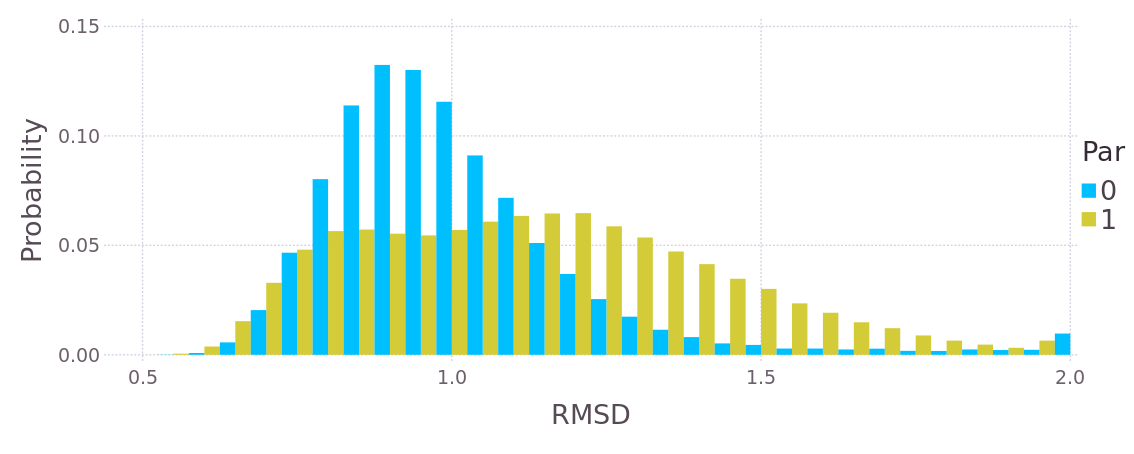

In [43]:
bin_rms = collect(0.5:.05:2.)

# Histograma ponderado
his_0, bin_0 = WeightedHist(rmsd_lig0, bin_rms, fill(1., length(rmsd_lig0)), true);
his_1, bin_1 = WeightedHist(rmsd_lig1, bin_rms, fill(1., length(rmsd_lig1)), true);

df_his_rms = DataFrame(Probability = [ his_0 ; his_1 ],
    RMSD = [ bin_0 ; bin_1 ],
    Par = [ fill("0", length(his_0)) ;
        fill("1", length(his_1)) ]);

plot(df_his_rms, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    Coord.cartesian(xmin = .45, xmax = 2.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

#### RMSD
#### inter

In [44]:
### Volume 0 vs Volume 1
proto_rmsd_0_1 = readdlm(joinpath(home, pdb, "lig", "poblaciones", "inter", "rms2_0_1_4xcp"))[:, 2:end]
rmsd_0_1 = reshape(proto_rmsd_0_1, length(proto_rmsd_0_1));

In [45]:
# Histograma ponderado
bin_rms = collect(.5:.05:4.)
his_0_1, bin_0_1 = WeightedHist(rmsd_0_1, bin_rms, fill(1., length(rmsd_0_1)), true);

df_his_rms = DataFrame(Probability = his_0_1, RMSD = bin_0_1,
    Par = fill("0_1", length(his_0_1)));

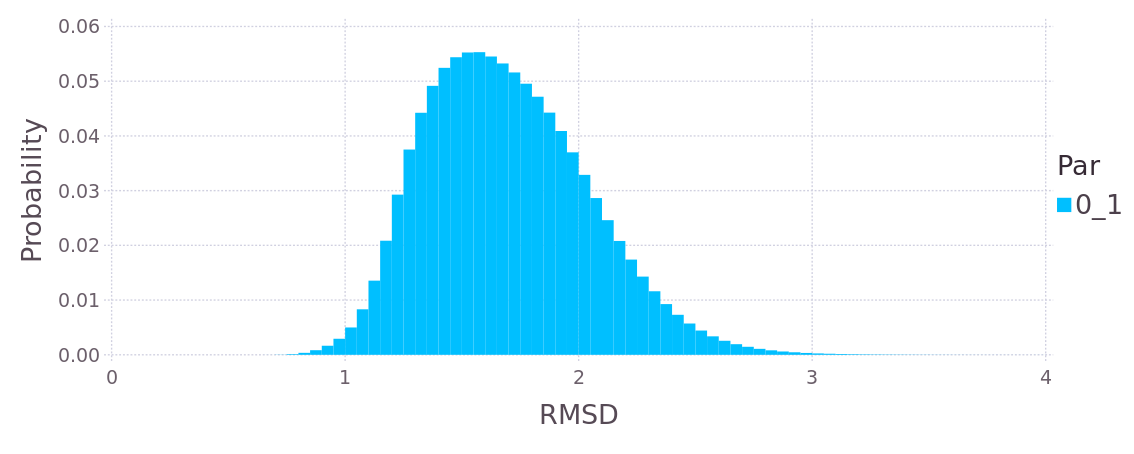

In [47]:
plot(df_his_rms, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    #Coord.cartesian(xmin = 5., xmax = 32.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

### LIG

In [48]:
const c1 = 2427
const cg = 2444

2444

#### distancia

In [122]:
# Leo distancias
dis_lig_lig0 = readdlm(joinpath(rtdos, "dis_lig_lig0"))[:, 1]
dis_lig_lig1 = readdlm(joinpath(rtdos, "dis_lig_lig1"))[:, 1]

bin_dis = collect(4.:.3:20.)

# Histograma ponderado
bin_0, his_0 = WeightedHist(dis_lig_lig0, bin_dis, fill(1., length(dis_lig_lig0)), true);
bin_1, his_1 = WeightedHist(dis_lig_lig1, bin_dis, fill(1., length(dis_lig_lig1)), true);

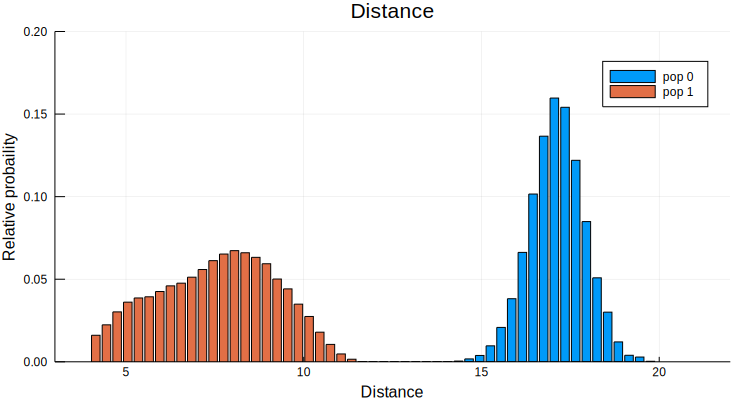

In [125]:
plt_dis_lig = bar(bin_0, his_0,
    xlims = (3, 22), ylims = (0, .2),
    yaxis = "Relative probaility", xaxis = "Distance", title = "Distance",
    label = "pop 0", size = (750, 400))
bar!(plt_dis_lig, bin_1, his_1,
    label = "pop 1")

#### Leo el RMSD respecto al avg

In [55]:
rmsd_lig0_lig = readdlm(joinpath(home, pdb, "lig", "poblaciones", "lig", "intra", string("rmsd_lig0_lig")))[:, 2]
rmsd_lig1_lig = readdlm(joinpath(home, pdb, "lig", "poblaciones", "lig", "intra", string("rmsd_lig1_lig")))[:, 2];

#### Guardo el frame más similar al avg

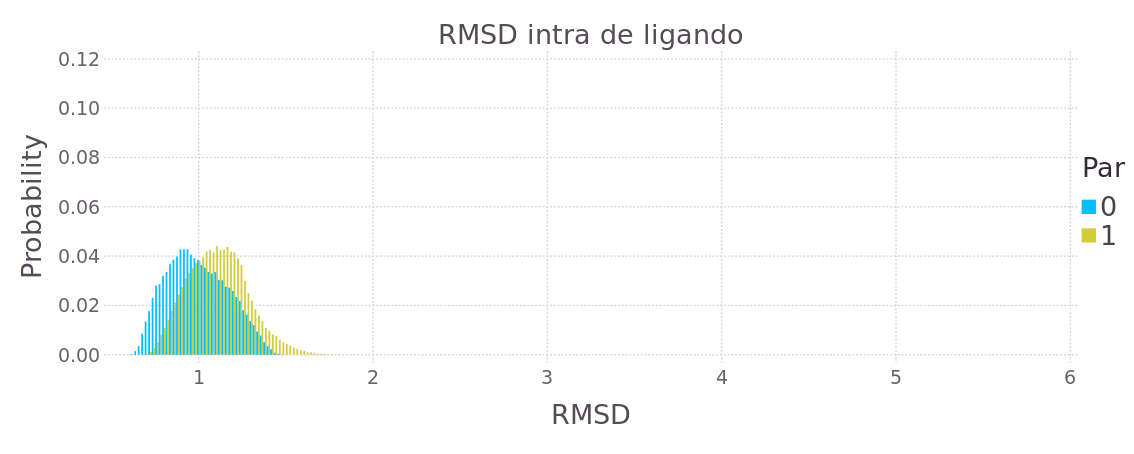

In [57]:
bin_rms = collect(0.5:.02:2.5)

# Histograma ponderado
his_0, bin_0 = WeightedHist(rmsd_lig0_lig, bin_rms, fill(1., length(rmsd_lig0_lig)), true);
his_1, bin_1 = WeightedHist(rmsd_lig1_lig, bin_rms, fill(1., length(rmsd_lig1_lig)), true);

df_his_rms_lig_poc = DataFrame(Probability = [ his_0 ; his_1 ],
    RMSD = [ bin_0 ; bin_1 ],
    Par = [ fill("0", length(his_0)) ; fill("1", length(his_1)) ]);

plot(df_his_rms_lig_poc, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    Guide.title("RMSD intra de ligando"),

    Coord.cartesian(xmin = .5, xmax = 6., ymax = .12),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

#### inter

In [58]:
### Volume 0 vs Volume 1
proto_rms_lig_0_1 = readdlm(joinpath(home, pdb, "lig", "poblaciones", "lig", "inter", string("rms2_0_1_lig")))
rms_lig_0_1 = reshape(proto_rms_lig_0_1, length(proto_rms_lig_0_1));

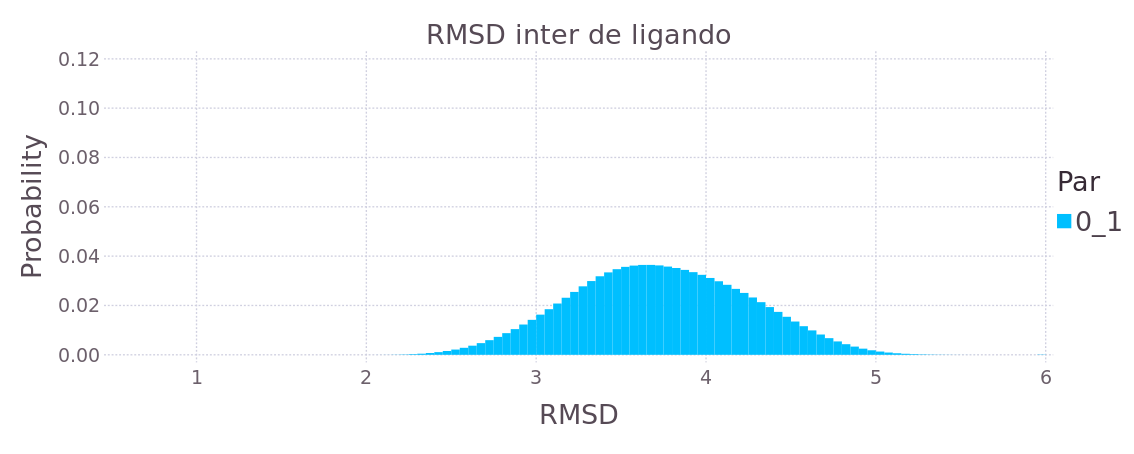

In [59]:
# Histograma ponderado
bin_rms = collect(2.:.05:6)
his_0_1, bin_0_1 = WeightedHist(rms_lig_0_1, bin_rms, fill(1., length(rms_lig_0_1)), true);

df_rms_lig_0_1 = DataFrame(Probability = his_0_1, RMSD = bin_0_1,
    Par = fill("0_1", length(his_0_1)));

plot(df_rms_lig_0_1, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    Guide.title("RMSD inter de ligando"),

    Coord.cartesian(xmin = .5, xmax = 6., ymax = .12),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

# Pocket

In [60]:
rmsd_lig_poc_0_aa = readdlm(joinpath(home, pdb, "lig", "poblaciones", "pocket", "intra", string("rms_lig0_poc_aa")))[:, 2]
rmsd_lig_poc_1_aa = readdlm(joinpath(home, pdb, "lig", "poblaciones", "pocket", "intra", string("rms_lig1_poc_aa")))[:, 2];

rmsd_lig_poc_0_ca = readdlm(joinpath(home, pdb, "lig", "poblaciones", "pocket", "intra", string("rms_lig0_poc_ca")))[:, 2]
rmsd_lig_poc_1_ca = readdlm(joinpath(home, pdb, "lig", "poblaciones", "pocket", "intra", string("rms_lig1_poc_ca")))[:, 2];;

### RMSD 
### intra

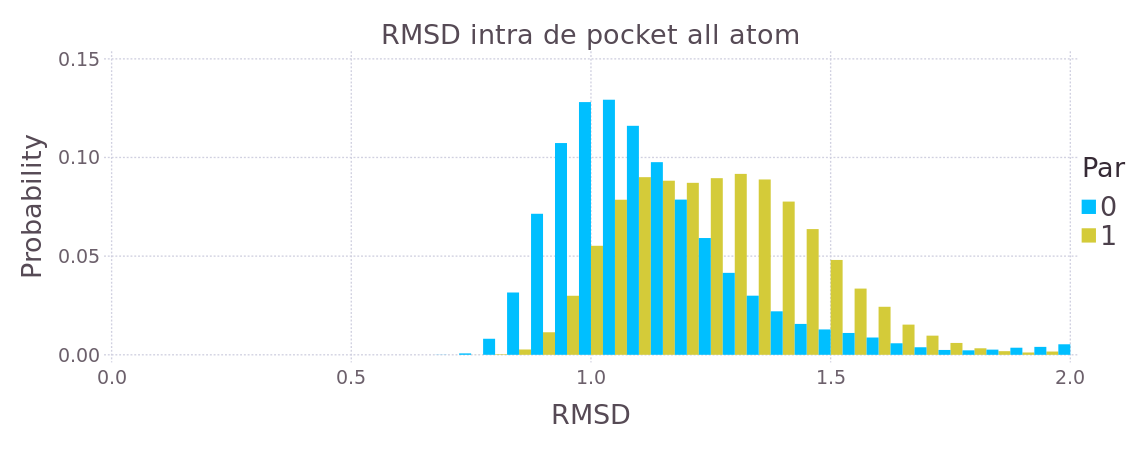

In [63]:
bin_rms = collect(0.5:.05:2.)

# Histograma ponderado
his_0, bin_0 = WeightedHist(rmsd_lig_poc_0_aa, bin_rms, fill(1., length(rmsd_lig_poc_0_aa)), true);
his_1, bin_1 = WeightedHist(rmsd_lig_poc_1_aa, bin_rms, fill(1., length(rmsd_lig_poc_1_aa)), true);

df_his_rms_lig_poc = DataFrame(Probability = [ his_0 ; his_1 ],
    RMSD = [ bin_0 ; bin_1 ],
    Par = [ fill("0", length(his_0)) ; fill("1", length(his_1)) ]);

plot(df_his_rms_lig_poc, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    Guide.title("RMSD intra de pocket all atom"),

    #Coord.cartesian(xmin = .45, xmax = 2.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

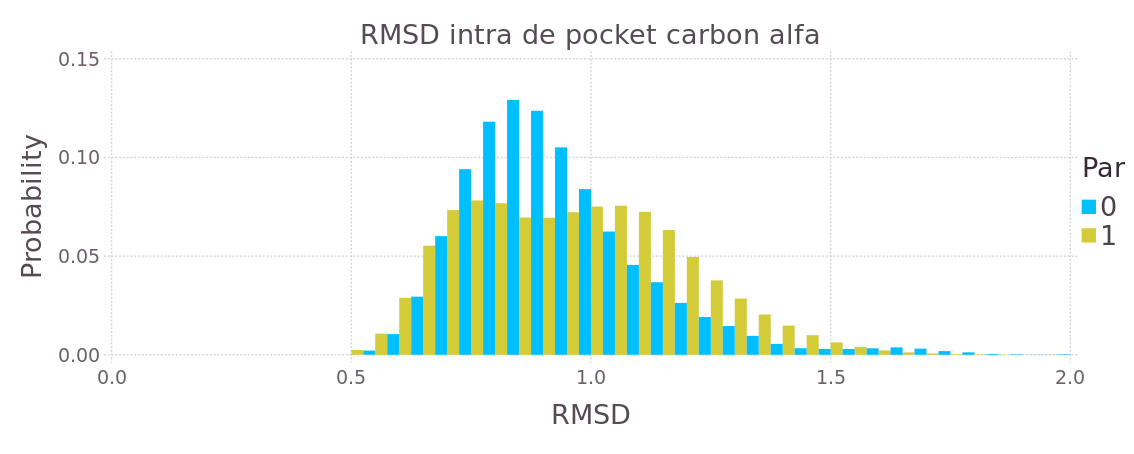

In [62]:
bin_rms = collect(0.5:.05:2.)

# Histograma ponderado
his_0, bin_0 = WeightedHist(rmsd_lig_poc_0_ca, bin_rms, fill(1., length(rmsd_lig_poc_0_ca)), true);
his_1, bin_1 = WeightedHist(rmsd_lig_poc_1_ca, bin_rms, fill(1., length(rmsd_lig_poc_1_ca)), true);

df_his_rms_lig_poc = DataFrame(Probability = [ his_0 ; his_1 ],
    RMSD = [ bin_0 ; bin_1 ],
    Par = [ fill("0", length(his_0)) ; fill("1", length(his_1)) ]);

plot(df_his_rms_lig_poc, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    Guide.title("RMSD intra de pocket carbon alfa"),

    #Coord.cartesian(xmin = .45, xmax = 2.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

#### RMSD
#### inter

In [64]:
### all atom
proto_rmsd_lig_poc_0_1_aa = readdlm(joinpath(
        home, pdb, "lig", "poblaciones", "pocket", "inter", "rms2_0_1_4xcp_poc_aa"))[:, 2:end]
rmsd_lig_poc_0_1_aa = reshape(proto_rmsd_lig_poc_0_1_aa, length(proto_rmsd_lig_poc_0_1_aa));

### carbon alpha
proto_rmsd_lig_poc_0_1_ca = readdlm(joinpath(
        home, pdb, "lig", "poblaciones", "pocket", "inter", "rms2_0_1_4xcp_poc_ca"))[:, 2:end]
rmsd_lig_poc_0_1_ca = reshape(proto_rmsd_lig_poc_0_1_ca, length(proto_rmsd_lig_poc_0_1_ca));

In [65]:
# Histograma ponderado
bin_rms = collect(.5:.05:4.)
his_0_1, bin_0_1 = WeightedHist(rmsd_lig_poc_0_1_aa, bin_rms, fill(1., length(rmsd_0_1)), true);

df_rms_lig_poc_0_1_aa = DataFrame(Probability = his_0_1, RMSD = bin_0_1,
    Par = fill("0_1", length(his_0_1)));

# Histograma ponderado
bin_rms = collect(.5:.05:4.)
his_0_1, bin_0_1 = WeightedHist(rmsd_lig_poc_0_1_ca, bin_rms, fill(1., length(rmsd_0_1)), true);

df_rms_lig_poc_0_1_ca = DataFrame(Probability = his_0_1, RMSD = bin_0_1,
    Par = fill("0_1", length(his_0_1)));

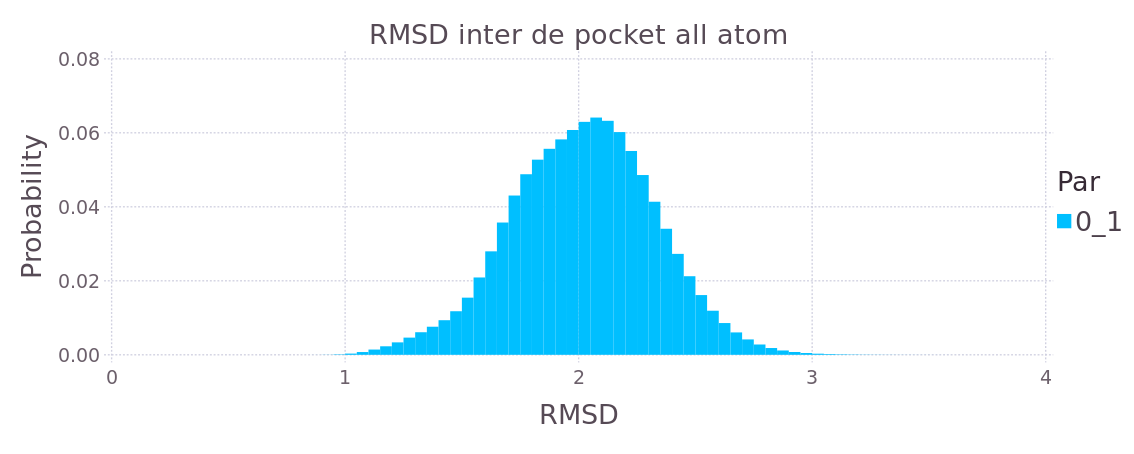

In [66]:
plot(df_rms_lig_poc_0_1_aa, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    Guide.title("RMSD inter de pocket all atom"),

    #Coord.cartesian(xmin = 5., xmax = 32.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

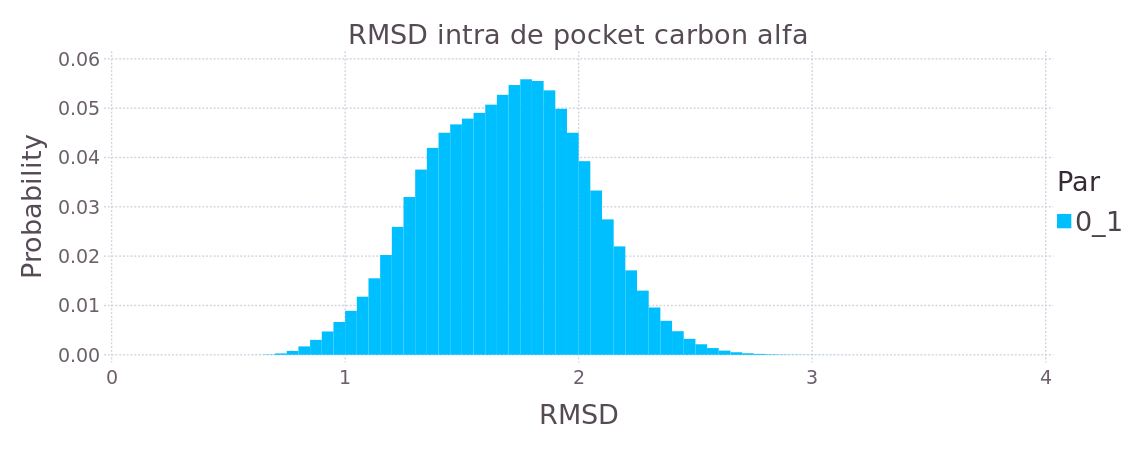

In [67]:
plot(df_rms_lig_poc_0_1_ca, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    Guide.title("RMSD intra de pocket carbon alfa"),
    
    #Coord.cartesian(xmin = 5., xmax = 32.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

In [23]:
# Projecciones de PCA
df_prj_lig = DataFrame(PCA1 = smooth_prj_1_lig, PCA2 = smooth_prj_2_lig);
save(joinpath(rtdos, string("2his_prj_lig_", pdb, ".csv")), df_prj_lig, quotechar = nothing)

# Guardo distancias
df_dis_lig_lig0 = DataFrame(lig_dis = dis_lig_lig0)
df_dis_lig_lig1 = DataFrame(lig_dis = dis_lig_lig1)
save(joinpath(rtdos, string("dis_4xcp_lig0_", pdb, ".csv")), df_dis_lig_lig0, quotechar = nothing)
save(joinpath(rtdos, string("dis_4xcp_lig1_", pdb, ".csv")), df_dis_lig_lig1, quotechar = nothing)

# Volumenes de poblaciones por ligando


# idx_lig_0 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_idx_lig0")))[:, 1])
# idx_lig_1 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_idx_lig1")))[:, 1])

In [174]:
############## CSV ##############
# Projecciones de PCA
df_prj = DataFrame(PCA1 = smooth_prj_1_lig, PCA2 = smooth_prj_2_lig)
save(joinpath(rtdos, string("2his_prj_lig_", pdb, ".csv")), df_prj, quotechar = nothing)

# Volumenes
df_vol0 = DataFrame(Volumen = trj_vol0)
save(joinpath(rtdos, string("his_vol_lig0", pdb, ".csv")), df_vol0, quotechar = nothing)
df_vol1 = DataFrame(Volumen = trj_vol1)
save(joinpath(rtdos, string("his_vol_lig1", pdb, ".csv")), df_vol1, quotechar = nothing)


# Distancias
df_dis_0 = DataFrame(dis = dis_lig_lig0)
save(joinpath(rtdos, string("dis_lig0_", pdb, ".csv")), df_dis_0, quotechar = nothing)
df_dis_1 = DataFrame(dis = dis_lig_lig1)
save(joinpath(rtdos, string("dis_lig1_", pdb, ".csv")), df_dis_1, quotechar = nothing)

############## PNG ##############
png(plt_dis_lig, joinpath(rtdos, "papel", string("plt_dis_lig_", pdb)))
png(plt_2his, joinpath(rtdos, "papel", string("plt_2his_lig_", pdb, ".png")))